In [1]:
import pandas as pd
import numpy as np
import padasip as pa
import matplotlib.pylab as plt
import seaborn as sns
import os

%matplotlib inline
SEED = 121
np.random.seed(SEED)

### Adaptive filter (Example with LMS)

Let's try to predict the future value of the given equation.

$
d(k)= a_1 s(k) + a_2 s(k−1) + a_3 s(k−2) + a_4 s(k−3) + a_5 s(k-4)
$

In [2]:
N = 200  # the overall time series size
n = 5  # size of sample we want to feed into the filter
s = np.random.random(N)  # generate the source input
d = np.zeros(N)  # initialize the target array
for k in range((n-1), N):
    d[k] = 2*s[k] + 0.9*s[k-1] - 2*s[k-2] + 0.3*s[k-3] + 100*s[k-4]
    
d = d[4: ]
x = pa.input_from_history(s, n)  # prep the input to filter
print(f'Check the source input length: {len(s)}')
print(f'Check the input length to filter: {len(x)}')
print(f'Check the target length: {len(d)}')

Check the source input length: 200
Check the input length to filter: 196
Check the target length: 196


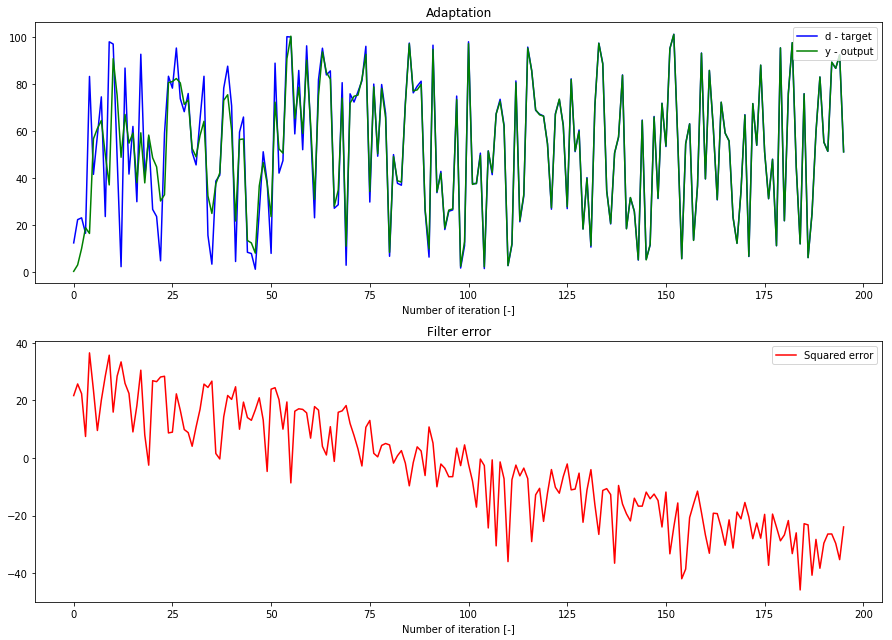

In [3]:
f = pa.filters.FilterLMS(mu=0.4, n=n)  # define the filter
y, e, w = f.run(d, x)

plt.figure(figsize=(12.5,9))
plt.subplot(211)
plt.title("Adaptation")
plt.xlabel("Number of iteration [-]")
plt.plot(d, "b", label="d - target")
plt.plot(y, "g", label="y - output")
plt.legend()

plt.subplot(212)
plt.title("Filter error")
plt.xlabel("Number of iteration [-]")
plt.plot(pa.misc.logSE(e), "r", label="Squared error")
plt.legend()
plt.tight_layout()
plt.show()

### Stock prediction

In [4]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce')
df = pd.read_csv('../data/datasets_1840_3212_Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016.csv',
                parse_dates=['Date'],
                index_col='Date',
                date_parser=dateparse)
df.sort_index(inplace=True)
print(f'Data shape: {df.shape}')
display(df.head())

Data shape: (1226, 6)


,Open,High,Low,Close,Volume,Stock Trading
Date,,,,,,
2012-01-04,14050,14050,13700,13720,559100,7719804000
2012-01-05,13720,13840,13600,13800,511500,7030811000
2012-01-06,13990,14030,13790,13850,765500,10635609000
2012-01-10,13890,14390,13860,14390,952300,13533413000
2012-01-11,14360,14750,14280,14590,1043400,15191988000


We will keep the first 1000 closing prices to demonstrate the adaptive filter

In [5]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts['Close'] = pd.to_numeric(ts['Close'] , errors='coerce')
ts.dropna(inplace=True)
ts.drop(['Open', 'High', 'Volume', 'Low', 'Stock Trading'], axis=1, inplace=True)

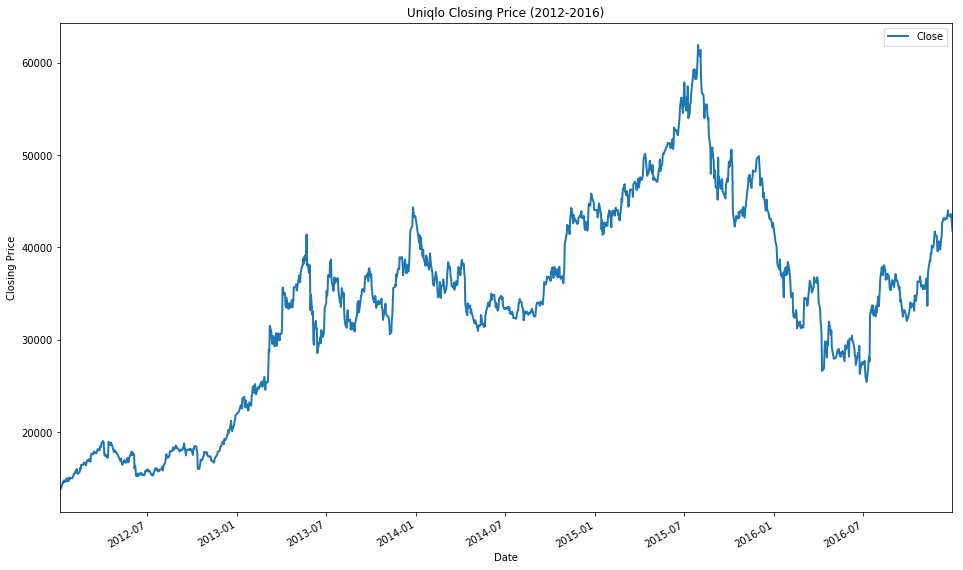

In [6]:
fig, ax = plt.subplots(figsize=(16, 10))
ts.plot(ax=ax, lw=2)
plt.ylabel('Closing Price')
plt.title('Uniqlo Closing Price (2012-2016)')
plt.show()

In [7]:
n = 5
s = ts['Close'].values.flatten()[: 1000]  # initial timeseries data
x = pa.input_from_history(s, n)  # input matrix
N = len(x)
print(f'Total length of data: {len(s)}')
print(f'Total length of data (after delay): {N}')
d = np.zeros(len(x))

# define target
for i, k in enumerate(range((n-1), N)):
    d[i] = s[k+1]
    

Total length of data: 1000
Total length of data (after delay): 996


Now let's try different `mu` value for NLMS (Normalized Least-mean-squares) adaptive filter

In [8]:
def plot_filter_result(pred: np.ndarray, actual: np.ndarray, error: np.ndarray, n: int,
                       mu_val: str='0.05', section_visual_flag: bool=True):
    _avg_error = round(np.mean(10*np.log10(error[: (len(error) - n)]**2)), 2)
    plt.figure(figsize=(12.5, 20))
    plt.subplot(411)
    plt.title(f'NLMS (mu={mu_val})')
    plt.xlabel('No of iteration [-]')
    plt.plot(actual[: (len(actual)-n)], 'b', label='target')
    plt.plot(pred[: (len(pred)-n)], 'g', label='predict / output')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.title(f'Filter error (avg: {_avg_error})')
    plt.plot(10*np.log10(error[: (len(error) - n)]**2), 'r', label='Error')
    plt.axhline(y=_avg_error, color='black', lw=1, linestyle='--')
    if section_visual_flag:
        plt.subplot(413)
        plt.title('First 300 iterations')
        plt.xlabel(None)
        plt.plot(actual[: 300], "b", label='target')
        plt.plot(pred[: 300], "g", label='predict / output')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.title('Last 300 iterations')
        plt.xlabel(None)
        plt.plot(actual[(len(actual) - 300 - n): (len(actual) - n)],
                 "b", label='target')
        plt.plot(pred[(len(pred) - 300 - n): (len(pred) - n)],
                 "g", label='predict / output')
        plt.legend(loc='upper left')
        
    plt.tight_layout()
    plt.show()
    return None



Test various `mu` to test on NLMS algorithm of adaptive filter. The filter has been kept along with its respective average error.

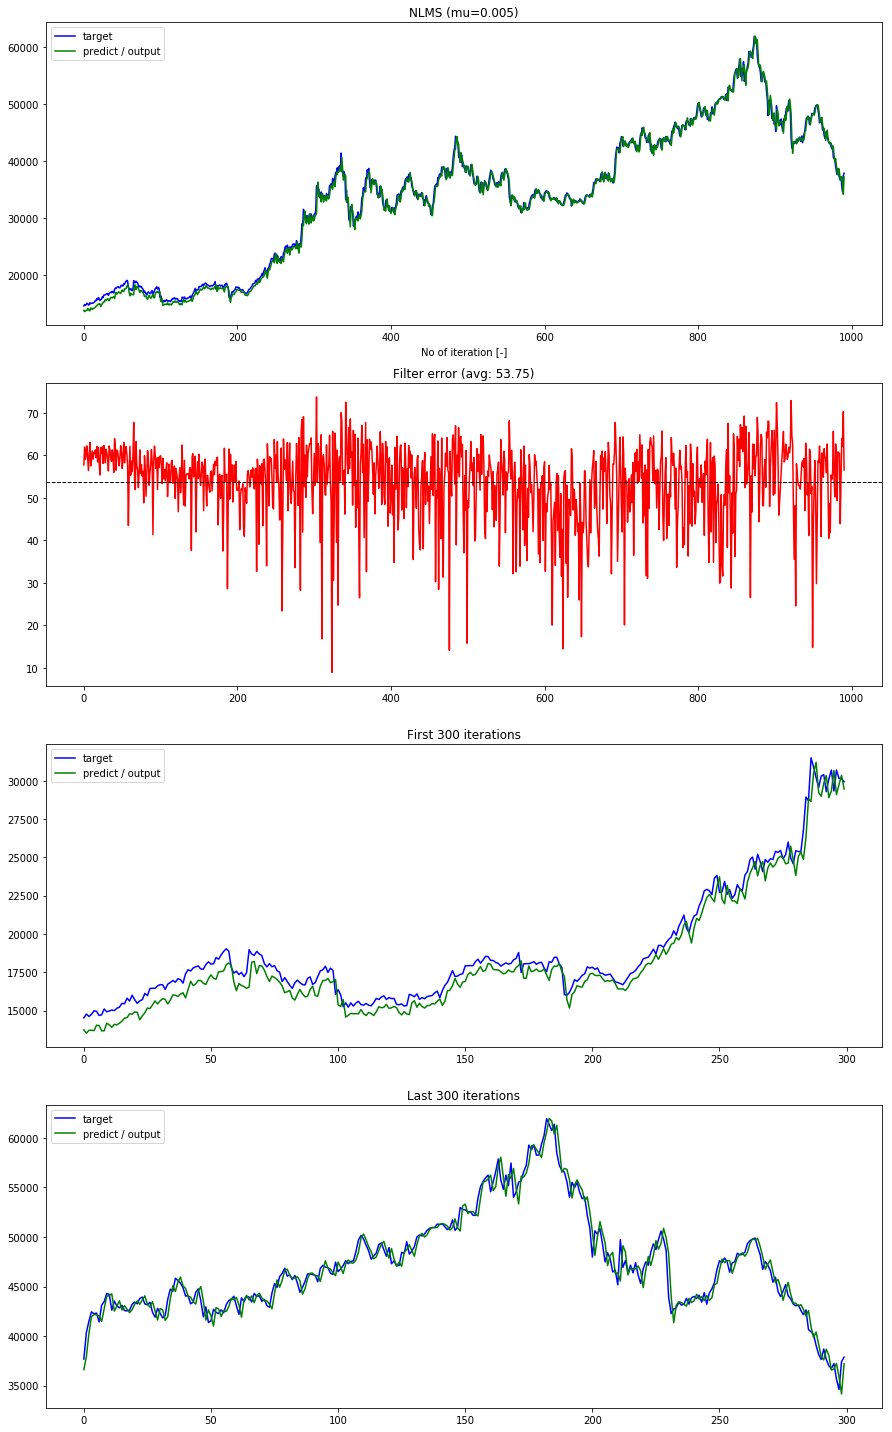

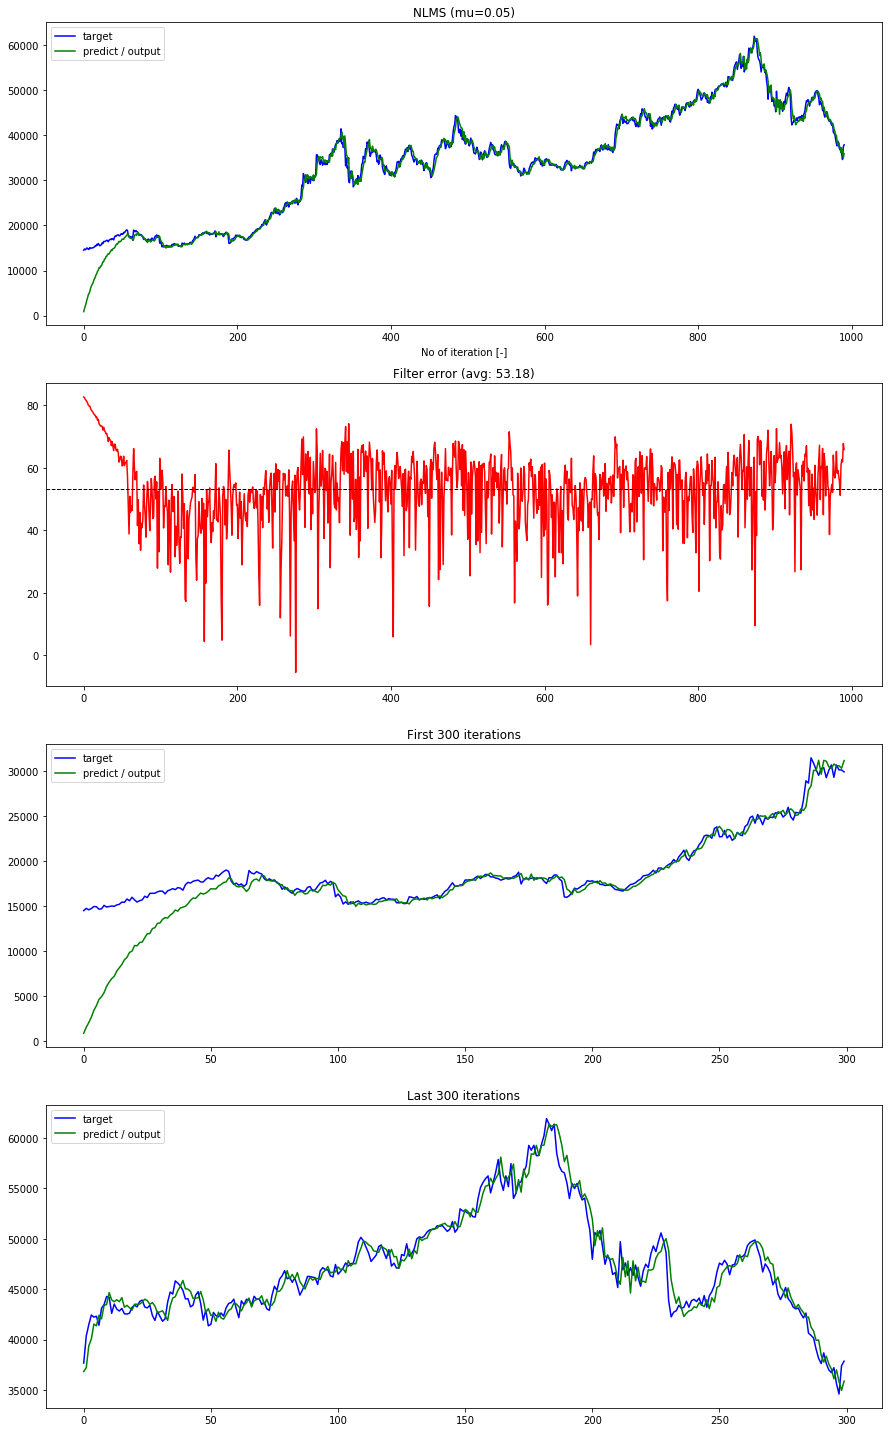

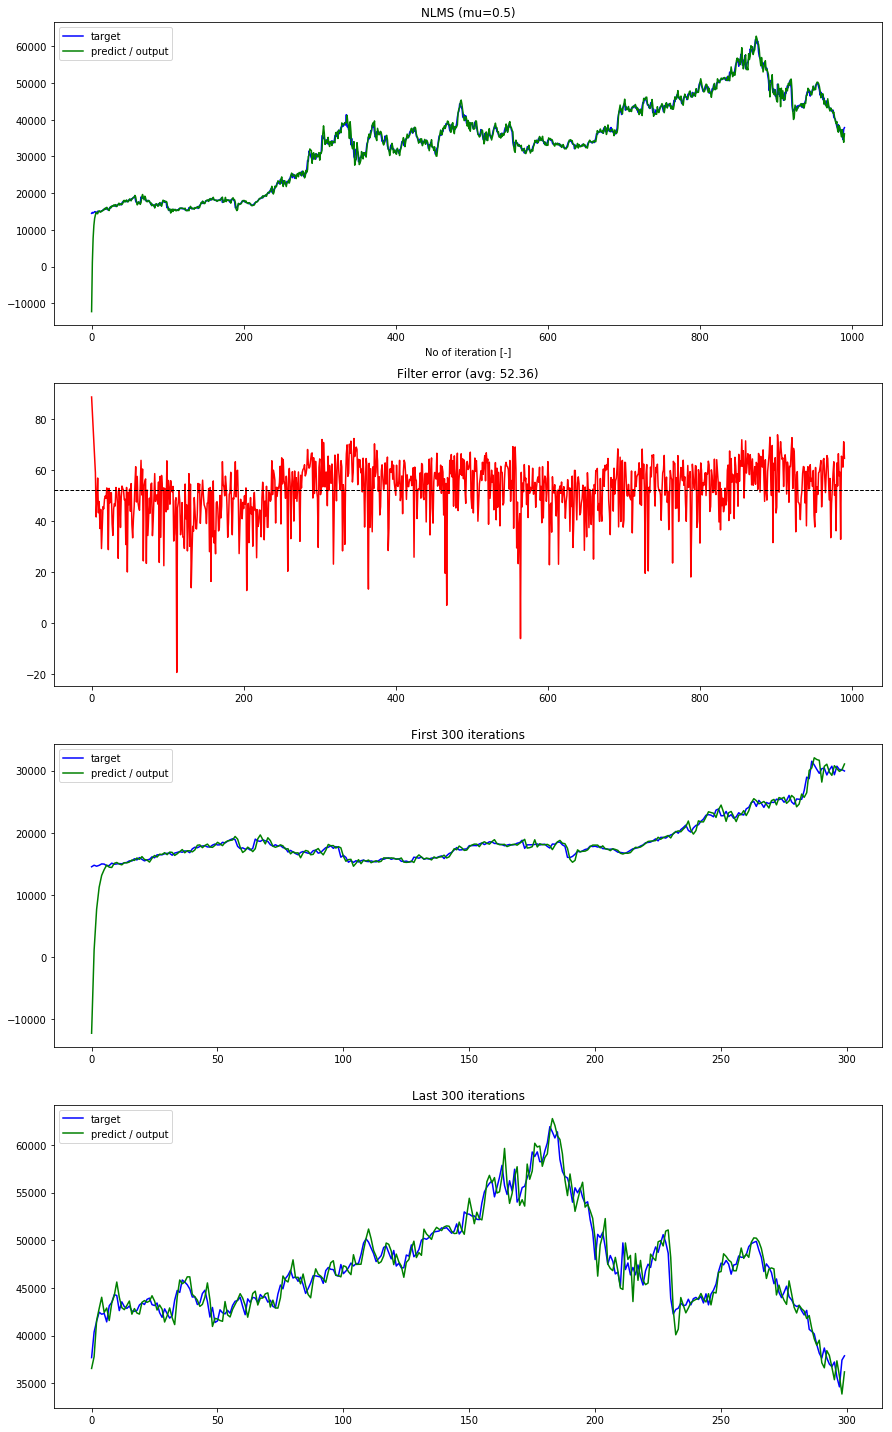

In [9]:
error_list = []
pa_list = []
for i, mu_ in enumerate([0.005, 0.05, 0.5]):
    f_nlms = pa.filters.FilterNLMS(n=n, mu=mu_, w='random')
    y, e, w = f_nlms.run(d, x)
    plot_filter_result(pred=y, actual=d, error=e, mu_val=mu_, n=n)
    _avg_error = round(np.mean(10*np.log10(e[: (len(e) - n)]**2)), 2)
    pa_list.append(f_nlms)
    error_list.append(_avg_error)

Next step is how we implement the filter on production (real-time basis). To simulate this, I will use the remaining data and loop to feed one iteration at a time.

Selected the filter with mu of 0.5
with avg eror of 52.36


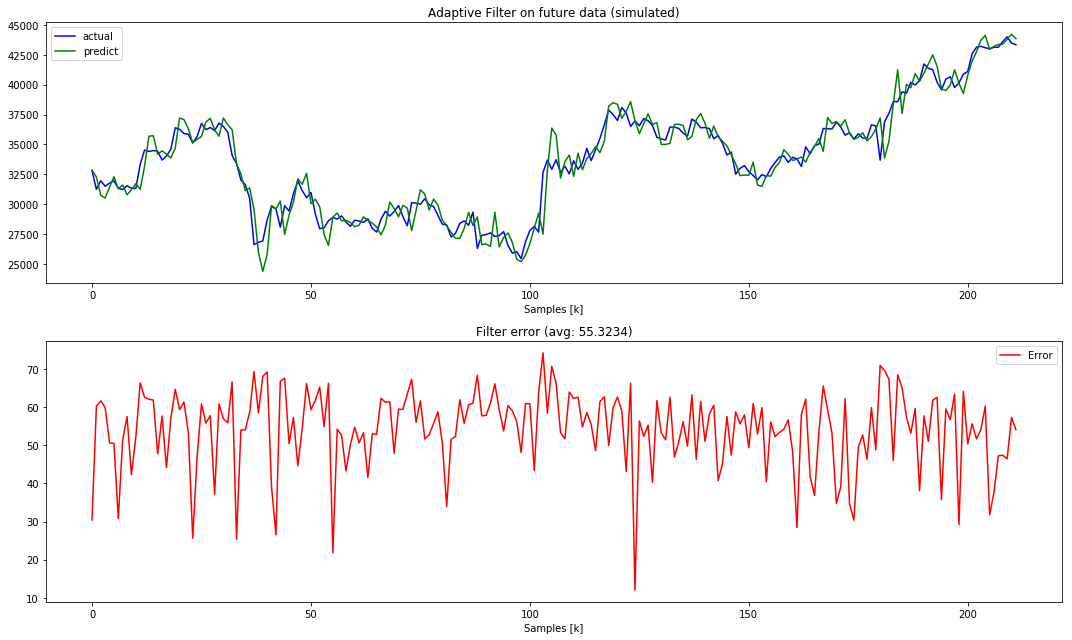

In [10]:
s_future = ts['Close'].values.flatten()[1000: ] 
filter_min_error = pa_list[np.argmin(error_list)]
print(f'Selected the filter with mu of {filter_min_error.mu}')
print(f'with avg eror of {error_list[np.argmin(error_list)]}') 
x_future = pa.input_from_history(s_future, n)
d_future = np.zeros(len(x_future))
N_future = len(x_future)

for i, k in enumerate(range((n-1), N_future)):
    d_future[i] = s_future[k+1]

actual_list = np.zeros(N_future)
predict_list = np.zeros(N_future)

# Simulate real-time prediction and update the filter
for k in range(N_future):
    x_input = x_future[k]
    y = filter_min_error.predict(x_input)
    d_actual = d_future[k]
    filter_min_error.adapt(d_actual, x_input)
    actual_list[k] = d_actual
    predict_list[k] = y
    
## show results
avg_error = np.round(np.mean(10*np.log10((actual_list -predict_list)**2)), 4)
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on future data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual_list[n: (len(actual_list)-n)], "b", label="actual")
plt.plot(predict_list[n: (len(predict_list)-n)], "g", label="predict")
plt.legend()
plt.subplot(212)
plt.title(f'Filter error (avg: {avg_error})')
plt.xlabel("Samples [k]")
plt.plot(10*np.log10((actual_list[n: (len(actual_list)-n)] - \
                      predict_list[n: (len(predict_list)-n)])**2), 
         "r", label="Error")
plt.legend()
plt.tight_layout()
plt.show()